# Booting Up

In [1]:
# importujemy niezbędne pakiety
import pandas as pd
import numpy as np


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
train['Survived'].value_counts() / train.shape[0]

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [6]:
# new submission - everyone dies
test['Survived'] = np.zeros(418)
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test['Survived']})
submit.to_csv('theyallperish.csv')

# Part 2: The Gender-Class Model

In [7]:
# Look at gender patterns
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
pd.crosstab(train['Sex'], train['Survived'], normalize=True)

Survived,0,1
Sex,,
female,0.090909,0.261504
male,0.525253,0.122334


In [9]:
pd.crosstab(train['Sex'], train['Survived'], normalize=0)

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [10]:
test['Survived'] = 0
test.loc[test['Sex'] == 'female', 'Survived'] = 1

# write to csv
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test['Survived']})
submit.to_csv('gender_model.csv')

In [11]:
# look at age patterns
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
train['Child'] = 0
train.loc[train['Age'] < 18, 'Child'] = 1

train.groupby(['Child', 'Sex'])['Survived'].sum()

Child  Sex   
0      female    195
       male       86
1      female     38
       male       23
Name: Survived, dtype: int64

In [13]:
train.groupby(['Child', 'Sex'])['Survived'].size()

Child  Sex   
0      female    259
       male      519
1      female     55
       male       58
Name: Survived, dtype: int64

In [14]:
train.groupby(['Child', 'Sex'])['Survived'].agg(lambda x: x.sum() / x.shape[0])

Child  Sex   
0      female    0.752896
       male      0.165703
1      female    0.690909
       male      0.396552
Name: Survived, dtype: float64

In [15]:
train['Fare2'] = pd.cut(train['Fare'], [0,10,20,30,float("inf")])
train.groupby(['Fare2', 'Pclass', 'Sex'])['Survived'].agg(lambda x: x.sum() / x.shape[0])

Fare2         Pclass  Sex   
(0.0, 10.0]   1       male      0.000000
              3       female    0.593750
                      male      0.109375
(10.0, 20.0]  2       female    0.914286
                      male      0.158730
              3       female    0.581395
                      male      0.236842
(20.0, 30.0]  1       female    0.857143
                      male      0.441176
              2       female    0.903226
                      male      0.160000
              3       female    0.333333
                      male      0.125000
(30.0, inf]   1       female    0.977011
                      male      0.365854
              2       female    1.000000
                      male      0.214286
              3       female    0.125000
                      male      0.240000
Name: Survived, dtype: float64

In [16]:
test['Survived'] = 0
test.loc[test['Sex'] == 'female', 'Survived'] = 1
test.loc[((test['Sex'] == 'female') & (test['Pclass'] == 3) & (test['Fare'] >=20)), 'Survived'] = 0


In [17]:
# write to csv
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test['Survived']})
submit.to_csv('genderclassmodel.csv')

# Part 3: Decision Trees

In [18]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

# transofrming string variables to Labels
le = LabelEncoder()
sex_labelled = le.fit(train['Sex'])
# we need to reshape to (-1,1) for datasets with one variable
X = le.transform(train['Sex']).reshape(-1,1)
Y = train['Survived']


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)


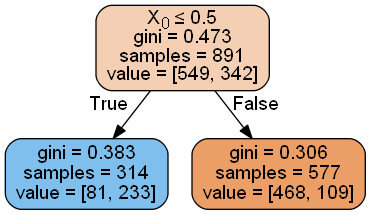

In [19]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
#we need to add Graphviz executables to path in order to plot decision trees
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [20]:
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    le.fit(train[column].astype(str))
    train[column] = le.transform(train[column].astype(str))
    test[column] = le.transform(test[column].astype(str))

In [21]:
# missing data in age:
train['Age'] = train['Age'].fillna(np.nanmean(train['Age']))
test['Age'] = test['Age'].fillna(np.nanmean(train['Age']))

test['Fare'] = test['Fare'].fillna(np.nanmean(train['Fare']))

X = train[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
Y = train['Survived']


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [22]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [23]:
predykcje_drzewo = clf.predict(test[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']])
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived':predykcje_drzewo})
submit.to_csv('myfullgrowntree.csv.csv')

# Part 4: Feature Engineering

In [24]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [25]:
# we can load data one more time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
test['Survived'] = np.nan

combi = pd.concat([train, test], ignore_index=True)
combi.loc[0,'Name']

'Braund, Mr. Owen Harris'

In [27]:
seria_list = combi['Name'].str.split('[.,]')
combi['Title'] = seria_list.apply(lambda x: x[1])

In [28]:
combi['Title'].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Ms                2
 Mlle              2
 Major             2
 Sir               1
 the Countess      1
 Lady              1
 Dona              1
 Mme               1
 Capt              1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64

In [29]:
combi['Title'].replace(' ', '', regex=True, inplace=True)

In [30]:
combi.loc[combi['Title'].isin(['Mme', 'Mlle']), 'Title'] = 'Mlle'
combi.loc[combi['Title'].isin(['Capt', 'Don', 'Major', 'Sir']), 'Title'] = 'Sir'
combi.loc[combi['Title'].isin(['Dona', 'Lady', 'theCountess', 'Jonkheer']), 'Title'] = 'Lady'

In [31]:
combi['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Dr          8
Rev         8
Sir         5
Lady        4
Col         4
Mlle        3
Ms          2
Name: Title, dtype: int64

In [32]:
combi['Family_size'] = combi['SibSp'] + combi['Parch'] + 1

In [33]:
# family surname
seria_list = combi['Name'].str.split('[.,]')
surnames = seria_list.apply(lambda x: x[0])
combi['Surname'] = surnames

In [34]:
combi['FamilyID'] = combi.apply(lambda x: '{}{}'.format(x['Family_size'], x['Surname']), axis=1)

In [35]:
combi.loc[combi['Family_size'] <= 2, 'FamilyID'] = 'Small'

In [36]:
combi['FamilyID'].value_counts().head()

Small         1025
11Sage          11
7Andersson       9
8Goodwin         8
7Asplund         7
Name: FamilyID, dtype: int64

In [37]:
lista = combi['FamilyID'].value_counts()
male_rodziny = lista[lista <=2].index.tolist()
combi.loc[combi['FamilyID'].isin(male_rodziny), 'FamilyID'] = 'Small'

In [38]:
train = combi.loc[0:890,]
test = combi.loc[891:1309,]

In [39]:
for column in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    le.fit(train[column].astype(str))
    train.loc[:,column] = le.transform(train[column].astype(str))
    test.loc[:,column] = le.transform(test[column].astype(str))
    
# filling missing data
train.loc[:,'Age'] = train['Age'].fillna(np.nanmean(train['Age']))
test.loc[:,'Age'] = test['Age'].fillna(np.nanmean(train['Age']))
test.loc[:,'Fare'] = test['Fare'].fillna(np.nanmean(train['Fare']))

c:\program files\python36\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
X = train[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family_size', 'Title']]
Y = train['Survived']


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [41]:
predykcje_drzewo = clf.predict(test[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','Family_size', 'Title']])
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived':predykcje_drzewo})
submit.to_csv('myfullgrowntree_with_features.csv')

# Part 5 : RandomForest

In [42]:
# we can load data one more time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test['Survived'] = np.nan

combi = pd.concat([train, test], ignore_index=True)
combi.loc[0,'Name']
seria_list = combi['Name'].str.split('[.,]')
combi['Title'] = seria_list.apply(lambda x: x[1])
combi['Title'].replace(' ', '', regex=True, inplace=True)
combi.loc[combi['Title'].isin(['Mme', 'Mlle']), 'Title'] = 'Mlle'
combi.loc[combi['Title'].isin(['Capt', 'Don', 'Major', 'Sir']), 'Title'] = 'Sir'
combi.loc[combi['Title'].isin(['Dona', 'Lady', 'theCountess', 'Jonkheer']), 'Title'] = 'Lady'
combi['Family_size'] = combi['SibSp'] + combi['Parch'] + 1

# family surname
seria_list = combi['Name'].str.split('[.,]')
surnames = seria_list.apply(lambda x: x[0])
combi['Surname'] = surnames
combi['FamilyID'] = combi.apply(lambda x: '{}{}'.format(x['Family_size'], x['Surname']), axis=1)
combi.loc[combi['Family_size'] <= 2, 'FamilyID'] = 'Small'
lista = combi['FamilyID'].value_counts()
male_rodziny = lista[lista <=2].index.tolist()
combi.loc[combi['FamilyID'].isin(male_rodziny), 'FamilyID'] = 'Small'





In [43]:
combi['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [44]:
# decision tree to 
for column in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    le.fit(combi[column].astype(str))
    combi.loc[:,column] = le.transform(combi[column].astype(str))    

# we need to fill Fare var
combi.loc[:,'Fare'] = combi['Fare'].fillna(np.nanmean(combi['Fare']))

X = combi.loc[~combi['Age'].isnull(), ['Sex', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family_size', 'Title']]
Y =  combi.loc[~combi['Age'].isnull(), ['Age']]
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, Y)


In [45]:

combi.loc[combi['Age'].isnull(), 'Age'] =clf.predict(combi.loc[combi['Age'].isnull(), ['Sex', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family_size', 'Title']])

In [46]:
combi.describe()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Family_size
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000,1309.000000
mean,29.943551,1.495034,33.295479,0.385027,655.000000,2.294882,0.644003,0.498854,0.383838,5.586707,1.883881
std,13.942906,0.816130,51.738879,0.865560,378.020061,0.837836,0.478997,1.041658,0.486592,1.277124,1.583639
min,0.170000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,21.000000,1.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,0.000000,4.000000,1.000000
50%,28.000000,2.000000,14.454200,0.000000,655.000000,3.000000,1.000000,0.000000,0.000000,6.000000,1.000000
75%,38.500000,2.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,1.000000,6.000000,2.000000
max,80.000000,3.000000,512.329200,9.000000,1309.000000,3.000000,1.000000,8.000000,1.000000,10.000000,11.000000


In [47]:
train = combi.loc[0:890,]
test = combi.loc[891:1309,]

In [48]:
from sklearn.ensemble import RandomForestClassifier

X = train[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family_size', 'Title']]
Y = train['Survived']


clf = RandomForestClassifier(n_estimators=200, random_state=415)
clf = clf.fit(X, Y)

In [49]:
predykcje_las = clf.predict(test[['Sex', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family_size', 'Title']])

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived':predykcje_las})
submit.to_csv('random_forest_with_features.csv')